# ISLR2 - Survival Analysis Lab (lifelines)

In this notebook we provide a python implementation of the lab from the *Survival Analysis - Chapter 11* of the second edition of the book [An Introduction to Statistical
Learning (Second Edition)](https://www.statlearning.com/). You can find a free pdf version of the book [here](https://web.stanford.edu/~hastie/ISLRv2_website.pdf). We will use the [`lifelines`](https://lifelines.readthedocs.io/en/latest/) python package, which you can find in [this repository](https://github.com/CamDavidsonPilon/lifelines). There is a nice introduction into survival analysis on the [documentation](https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html). There are also many concrete examples and guidelines to use the package.

Please refer to the book for more details and explanations on the concepts. We focus on the lab implementation.

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')


plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

## Read Data

In this lab we want to analyze the *BrainCancer* data set. The data for the lab is provided as `.rda` [here](https://github.com/cran/ISLR2/blob/master/data/BrainCancer.rda). To read it as a [pandas](https://pandas.pydata.org/) data frame, I read it in [R](https://www.r-project.org/) and exported it in [feather](https://arrow.apache.org/docs/python/feather.html#:~:text=Feather%20is%20a%20portable%20file,Python%20(pandas)%20and%20R.) format.

In [2]:
bc_df = pd.read_feather('../Data/brain_cancer.feather')

bc_df.head()

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
1,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
2,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
3,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
4,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30


The column of interest is `time` (survival time). The variable `status` indicates whether the observation is *censored*. The other variables are additional covariates.

In [3]:
bc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   sex        88 non-null     category
 1   diagnosis  87 non-null     category
 2   loc        88 non-null     category
 3   ki         88 non-null     int32   
 4   gtv        88 non-null     float64 
 5   stereo     88 non-null     category
 6   status     88 non-null     int32   
 7   time       88 non-null     float64 
dtypes: category(4), float64(2), int32(2)
memory usage: 3.1 KB


Note that we have column `diagnosis` is missing one  value.

Let us plot the `time` distribution split by `status`.

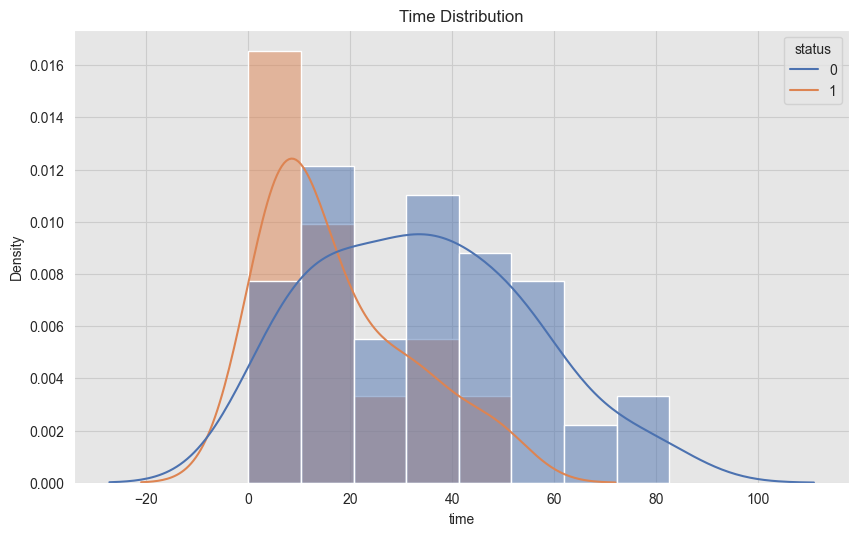

In [4]:
fig, ax = plt.subplots()
sns.histplot(x='time', data=bc_df, hue='status', stat='density', ax=ax)
sns.kdeplot(x='time', data=bc_df, hue='status', fill=False, ax=ax)
ax.set(title='Time Distribution');

## The Kaplan-Meier Survival Curve

Recall from *Chapter 11.5* that the [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) of the survival curve $S(T)$ is 

$$
\hat{S}(t) = \prod_{i : \: t_{i} \leq t} \left(1 - \frac{d_{i}}{n_{i}} \right)
$$

where with $t_{i}$ is a time when at least one event happened, $d_{i}$ is the number of events that happened at time $t_{i}$, and $n_{i}$ is the number of individuals known to have survived up to time $t_{i}$. We can use the [`KaplanMeierFitter`](https://lifelines.readthedocs.io/en/latest/fitters/univariate/KaplanMeierFitter.html) to compute this estimator.

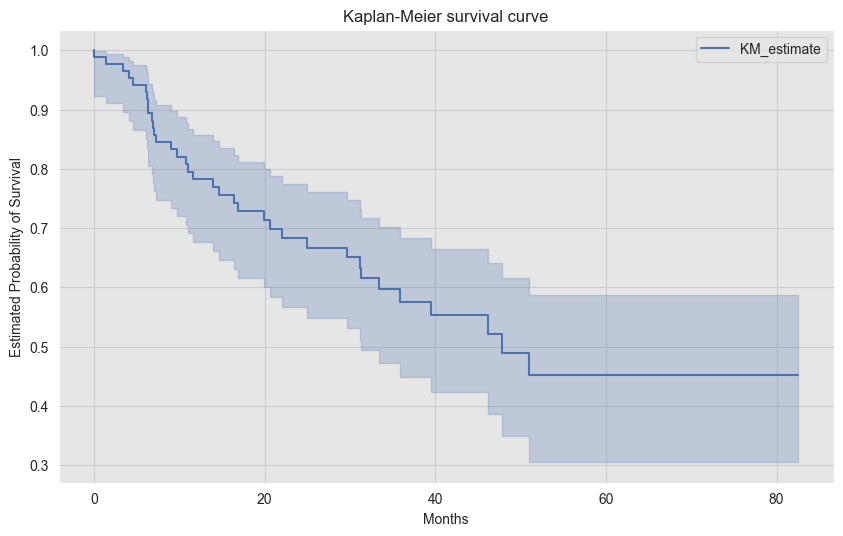

In [5]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

kmf.fit(durations=bc_df['time'], event_observed=bc_df['status'])

fig, ax =  plt.subplots()
kmf.plot_survival_function(color='C0',ax=ax)
ax.set(
    title='Kaplan-Meier survival curve',
    xlabel='Months',
    ylabel='Estimated Probability of Survival'
);

Compare with *FIGURE 11.2* in the book.

Let us now compute this estimator for each of the classes of the `sex` column.

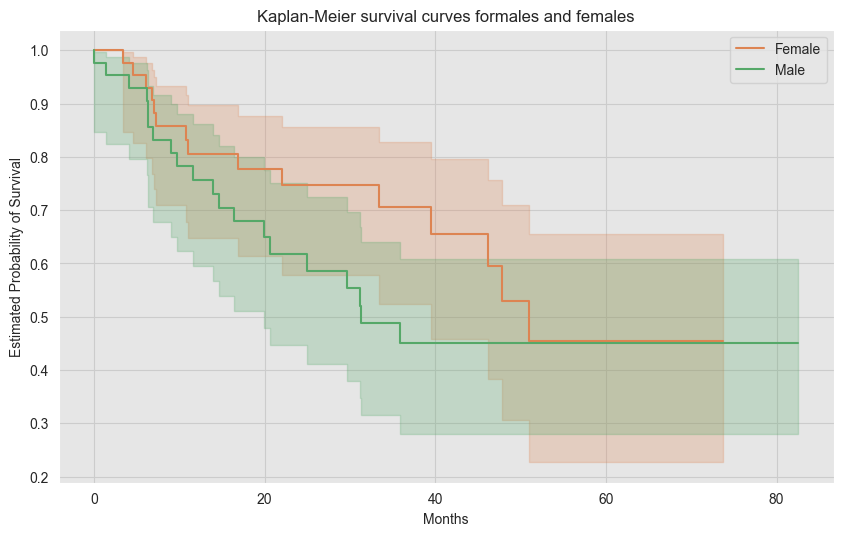

In [6]:
fig, ax =  plt.subplots()

for i, sex in enumerate(bc_df['sex'].unique()):

    kmf = KaplanMeierFitter()

    mask = f'sex == "{sex}"'
    
    kmf.fit(
        durations=bc_df.query(mask)['time'],
        event_observed=bc_df.query(mask)['status']
    )

    kmf.plot_survival_function(
        color=f'C{i + 1}',
        label=sex,
        ax=ax
    )

ax.set(
    title='Kaplan-Meier survival curves formales and females',
    xlabel='Months',
    ylabel='Estimated Probability of Survival'
);

## The Log-Rank Test

Let us now compute the [log-rank test](https://en.wikipedia.org/wiki/Logrank_test) to compare
the survival of males to females.

In [7]:
from lifelines.statistics import logrank_test

mask_female = f'sex == "Female"'
mask_male = f'sex == "Male"'

logrank_test_result = logrank_test(
    durations_A=bc_df.query(mask_female)['time'],
    durations_B=bc_df.query(mask_male)['time'],
    event_observed_A=bc_df.query(mask_female)['status'],
    event_observed_B=bc_df.query(mask_male)['status']
)

logrank_test_result.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

As mentioned in the book: *The resulting p-value is 0.23, indicating no evidence of a difference in survival between the two sexes.*

##  Regression Models With a Survival Response

Next, we move into regression analysis. We will focus in the [*The Proportional Hazards model*](https://en.wikipedia.org/wiki/Proportional_hazards_model), specifically the *Cox’s Proportional Hazards Model*. The main idea of this model is to assume the following form for the [Hazard function](https://en.wikipedia.org/wiki/Survival_analysis#Hazard_function_and_cumulative_hazard_function)

$$
h(t|x_i) = h_0(t) \exp \left( \sum_{j=1}^{p} \beta_jx_{ij}\right)
$$

where $h_0(t) \geq 0$ is the *baseline hazard* and $x_{i}$ are the covariates. Recall that the relation between the Hazard function and the survival curve is 

$$
S(t) = \exp \left( - \int_{0}^{t} h(\tau) d\tau\right)
$$

We can use the [`CoxPHFitter`](https://lifelines.readthedocs.io/en/latest/fitters/regression/CoxPHFitter.html) to estimate these type of models. The model features can be specified by R-like formulas, see [patsy](https://patsy.readthedocs.io/en/latest/).

### Model 1

Let us start by using just the `sex` feature.

In [8]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()

cph.fit(df=bc_df, duration_col='time', event_col='status', formula='sex')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 35
   partial log-likelihood = -137.43
         time fit was run = 2021-08-31 09:52:08 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
sex[T.Male]   0.41       1.50       0.34            -0.26             1.08                 0.77                 2.94

               z    p   -log2(p)
covariate                       
sex[T.Male] 1.19 0.23       2.10
---
Concordance = 0.56
Partial AIC = 276.86
log-likelihood ratio test = 1.44 on 1 df
-log2(p) of ll-ratio test = 2.12

Recall that *the score test from the Cox model is exactly equal to the log rank test statistic*. We indeed see that *there is no clear evidence for
a difference in survival between males and females*.

### Model 2

For the final model we add all the features available (note that we need to remove the row with missing values).

In [9]:
cph.fit(
    df=bc_df.dropna(axis=0),
    duration_col='time',
    event_col='status',
    formula='sex + diagnosis + loc + ki + gtv + stereo'
)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 87 total observations, 52 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 87
number of events observed = 35
   partial log-likelihood = -116.75
         time fit was run = 2021-08-31 09:52:09 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
diagnosis[T.LG glioma]   0.92       2.50       0.64            -0.34             2.17                 0.71                 8.72
diagnosis[T.HG glioma]   2.15       8.62       0.45             1.27             3.04                 3.57                20.85
diagnosis[T.Other]       0.89       2.42       0.66            -0.40             2.18                 0.67                 8.80
gtv                      0.03       1.03       0.02            -0.01             0.08                 0.99                 1.08
ki                      -0.05       0.95       0.02            -0.09            -0.02                 0.91                 0.98
loc[T.Supratentorial]    0.44       1.55       0.70            -0.94             1.82                 0.39                 6.17
sex[T.Male]              0.18       1.20       0.36            -0.52             0.89                 0.59                 2.44
stereo[T.SRT]            0.18       1.19       0.60            -1.00             1.36                 0.37                 3.88

                           z      p   -log2(p)
covariate                                     
diagnosis[T.LG glioma]  1.43   0.15       2.72
diagnosis[T.HG glioma]  4.78 <0.005      19.14
diagnosis[T.Other]      1.35   0.18       2.49
gtv                     1.54   0.12       3.00
ki                     -3.00 <0.005       8.54
loc[T.Supratentorial]   0.63   0.53       0.91
sex[T.Male]             0.51   0.61       0.71
stereo[T.SRT]           0.30   0.77       0.38
---
Concordance = 0.79
Partial AIC = 249.50
log-likelihood ratio test = 41.37 on 8 df
-log2(p) of ll-ratio test = 19.10

Finally we plot the survival curves for the `diagnosis` variable. Here the baseline corresponds to meningioma.

<AxesSubplot:>

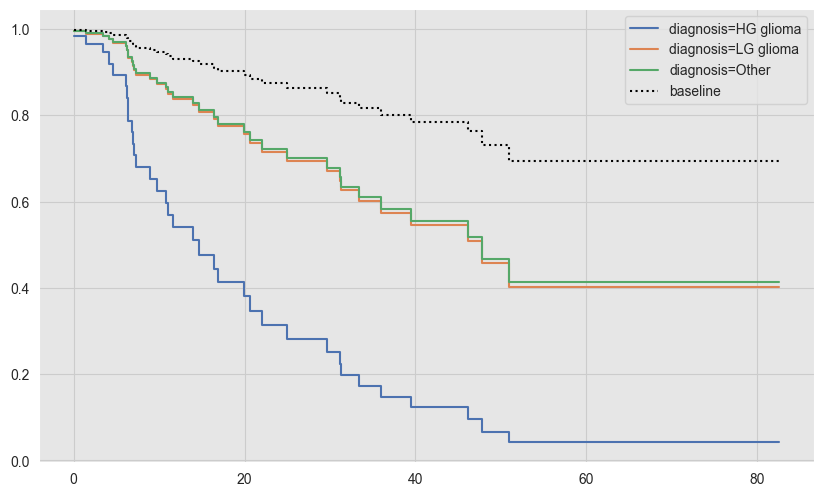

In [10]:
cph.plot_partial_effects_on_outcome(
    covariates='diagnosis',
    values=bc_df.dropna(axis=0)['diagnosis'].unique()[1:]
);

All of the results and plots coincide with the R implementation. The remaining labs can be done in a very similar way.